In [3]:
import pandas as pd
import sklearn
from sklearn.cluster import KMeans
NTS_dummy = pd.read_csv('/content/drive/MyDrive/socio_pred/UKDA-5340-tab/NTS_v2.csv')

In [33]:
NTS_dummy.shape

(2445, 137)

In [68]:
# reolace NA with zero
#na occurs for std of users with one trip, or count of users with no weekend trip
NTS_dummy = NTS_dummy.fillna(0)

In [104]:
NTS_dummy.columns

Index(['IndividualID', 'SurveyYear', 'Age_B04ID_4', 'Age_B04ID_5',
       'Age_B04ID_6', 'Age_B04ID_7', 'Age_B04ID_8', 'Age_B04ID_9',
       'Sex_B01ID_1', 'Sex_B01ID_2',
       ...
       'std_end_morning_wk', 'std_Distance_wk', 'std_Distance_ex_wk',
       'std_time_short_wk', 'std_time_mid_wk', 'std_time_long_wk',
       'std_travel_short_wk', 'std_travel_mid_wk', 'std_travel_long_wk',
       'Total Number of Trips'],
      dtype='object', length=137)

In [109]:
def kplot(df,k,norm=1):
  # f: number of features, default three sentiments
  mobility = df.iloc[:,38:]
  socio = df.drop(columns = ['IndividualID','SurveyYear']).iloc[:,0:36]

  features = np.array(mobility)

  if norm ==1:  #standardze
    scaler = MinMaxScaler()
    features = scaler.fit_transform(features)
  kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
  }
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(features)

  socio['label'] = kmeans.labels_
  mobility['label'] = kmeans.labels_

  
  return socio,mobility

In [168]:
socio,mobility = kplot(NTS_dummy,7,norm=1)

In [183]:
socio_cols = {'age' : socio.columns[0:6],
'sex' : socio.columns[6:8],
'marital' : socio.columns[8:10],
'income': socio.columns[10:13],
'work': socio.columns[13:16],
'hhincome': socio.columns[16:19],
'hh_struc': socio.columns[19:25],
'hh_work': socio.columns[25:28],
'hh_socialclass': socio.columns[28:34],
'urban_rural': socio.columns[34:36]}

In [111]:
mobility.groupby('label').size()

label
0    290
1    614
2    258
3    103
4    370
5    541
6    269
dtype: int64

Statistical Test


In [184]:
import scipy.stats as stats
def chi2stat(df,var):
  df = df.groupby('label').sum()[var]
  #for chi2 test, min freq should be at least 5
  var2 = (df>4).all()[(df>4).all()==True].index 
  
  chi2 = stats.chi2_contingency(df[var2])
  if len(var2)<2:
    print('Not enough data')
  print('P_value: ',chi2[1])
  return


In [185]:
vars = socio_cols.keys()

for v in vars:
  print(v)
  chi2stat(socio,socio_cols[v])
  print('-----')
  

age
P_value:  4.401395320842017e-40
-----
sex
P_value:  5.460927703645173e-13
-----
marital
P_value:  6.041172467416708e-06
-----
income
P_value:  1.502942376616397e-30
-----
work
P_value:  1.228560535182003e-77
-----
hhincome
P_value:  1.8134502882735015e-29
-----
hh_struc
P_value:  1.4674184651503782e-11
-----
hh_work
P_value:  5.4141734880288525e-48
-----
hh_socialclass
P_value:  1.4107879150819465e-47
-----
urban_rural
P_value:  0.025070927434767444
-----


In [118]:
mobility.corr().style.background_gradient(cmap='coolwarm')

In [119]:
socio.corr().style.background_gradient(cmap='coolwarm')


,Age_B04ID_4,Age_B04ID_5,Age_B04ID_6,Age_B04ID_7,Age_B04ID_8,Age_B04ID_9,Sex_B01ID_1,Sex_B01ID_2,married,not_married,IndIncome2002_B02ID_1,IndIncome2002_B02ID_2,IndIncome2002_B02ID_3,fulltime,parttime,not_working,HHIncome2002_B02ID_1,HHIncome2002_B02ID_2,HHIncome2002_B02ID_3,HHoldStruct_B02ID_1,HHoldStruct_B02ID_2,HHoldStruct_B02ID_3,HHoldStruct_B02ID_4,HHoldStruct_B02ID_5,HHoldStruct_B02ID_6,hh_fulltime,hh_parttime,hh_not_working,HRPSEGWorkStat_B01ID_1,HRPSEGWorkStat_B01ID_2,HRPSEGWorkStat_B01ID_3,HRPSEGWorkStat_B01ID_4,HRPSEGWorkStat_B01ID_5,HRPSEGWorkStat_B01ID_6,Settlement2011EW_B03ID_1,Settlement2011EW_B03ID_2,label
Age_B04ID_4,1.000000,-0.041167,-0.059561,-0.059133,-0.067378,-0.093793,0.014272,-0.014272,-0.161454,0.161454,0.113585,-0.086369,-0.049671,-0.014185,0.123476,-0.080221,-0.003958,-0.042443,0.042095,-0.047060,-0.074507,0.121739,-0.017882,-0.061764,0.127149,0.045608,0.017063,-0.061021,0.008899,0.034980,0.007543,0.021081,-0.051956,-0.023863,0.011510,-0.011510,-0.050301
Age_B04ID_5,-0.041167,1.000000,-0.143769,-0.142736,-0.162637,-0.226398,-0.022542,0.022542,-0.278867,0.278867,0.055247,0.002328,-0.085555,0.181033,-0.028644,-0.173217,-0.078836,-0.000250,0.066909,-0.059926,-0.098234,0.189511,0.031120,-0.019679,0.002936,0.151142,-0.030441,-0.139801,-0.009306,0.086862,0.059214,0.029935,-0.149559,0.014998,0.045751,-0.045751,-0.119839
Age_B04ID_6,-0.059561,-0.143769,1.000000,-0.206510,-0.235302,-0.327552,-0.013367,0.013367,-0.045406,0.045406,-0.108701,0.084507,0.044972,0.206232,0.011547,-0.231508,-0.096973,0.007188,0.075460,-0.120190,-0.185820,-0.127447,0.130983,0.405548,-0.033074,0.172258,0.037226,-0.210941,0.106854,0.089770,-0.009685,0.064193,-0.242261,0.069824,0.080834,-0.080834,-0.030279
Age_B04ID_7,-0.059133,-0.142736,-0.206510,1.000000,-0.233612,-0.325200,-0.047106,0.047106,0.056828,-0.056828,-0.107356,0.064851,0.070186,0.167255,0.056553,-0.224262,-0.084130,-0.005977,0.076617,-0.050544,-0.188905,-0.069999,0.035174,0.244954,0.105610,0.183578,0.046014,-0.229355,0.110020,0.108207,0.041316,0.001345,-0.235184,-0.008872,0.015821,-0.015821,-0.049642
Age_B04ID_8,-0.067378,-0.162637,-0.235302,-0.233612,1.000000,-0.370540,0.017550,-0.017550,0.090915,-0.090915,-0.104665,0.051469,0.084706,0.176181,0.008002,-0.196333,-0.072274,-0.077872,0.132223,-0.041144,-0.011140,0.183219,-0.055711,-0.150875,0.076039,0.161790,0.010905,-0.180859,0.055954,0.078169,0.058587,0.035959,-0.210083,0.036286,-0.032913,0.032913,-0.081577
Age_B04ID_9,-0.093793,-0.226398,-0.327552,-0.325200,-0.370540,1.000000,0.042691,-0.042691,0.125446,-0.125446,0.197551,-0.141034,-0.099105,-0.554204,-0.077060,0.657740,0.254930,0.077635,-0.286502,0.220259,0.387103,-0.148179,-0.098343,-0.359019,-0.159029,-0.525816,-0.061735,0.606657,-0.217298,-0.286619,-0.113313,-0.106972,0.664818,-0.082417,-0.079460,0.079460,0.219808
Sex_B01ID_1,0.014272,-0.022542,-0.013367,-0.047106,0.017550,0.042691,1.000000,-1.000000,0.074670,-0.074670,-0.184743,0.112517,0.119507,0.223464,-0.256126,-0.043013,-0.045718,0.013345,0.026486,-0.046891,0.026324,0.041661,-0.138678,0.006084,0.009941,0.029400,-0.045351,0.001101,0.007289,-0.034417,0.046205,-0.012825,0.013249,-0.037015,0.023369,-0.023369,-0.048240
Sex_B01ID_2,-0.014272,0.022542,0.013367,0.047106,-0.017550,-0.042691,-1.000000,1.000000,-0.074670,0.074670,0.184743,-0.112517,-0.119507,-0.223464,0.256126,0.043013,0.045718,-0.013345,-0.026486,0.046891,-0.026324,-0.041661,0.138678,-0.006084,-0.009941,-0.029400,0.045351,-0.001101,-0.007289,0.034417,-0.046205,0.012825,-0.013249,0.037015,-0.023369,0.023369,0.048240
married,-0.161454,-0.278867,-0.045406,0.056828,0.090915,0.125446,0.074670,-0.074670,1.000000,-1.000000,-0.032877,-0.015902,0.071015,-0.093950,0.028452,0.079383,-0.135393,0.028923,0.088114,-0.432387,0.195168,-0.080600,-0.169287,0.196077,0.050664,-0.027188,-0.010040,0.036282,0.026048,-0.014644,-0.027754,-0.031294,0.052761,-0.050879,-0.048862,0.048862,0.082682
not_married,0.161454,0.278867,0.045406,-0.056828,-0.090915,-0.125446,-0.074670,0.074670,-1

In [197]:
dependants = list(socio_cols.keys())

socio[socio_cols[dependants[0]]]

,Age_B04ID_4,Age_B04ID_5,Age_B04ID_6,Age_B04ID_7,Age_B04ID_8,Age_B04ID_9
0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2440,0.0,0.0,0.0,0.0,1.0,0.0
2441,0.0,0.0,0.0,1.0,0.0,0.0
2442,0.0,0.0,0.0,0.0,0.0,1.0
2443,0.0,0.0,0.0,0.0,0.0,1.0


Feature Importance

In [198]:
from sklearn.ensemble import RandomForestClassifier
from numpy import mean, std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# define dataset
x = mobility.iloc[:,:-1]
scaler = MinMaxScaler().fit(x)
x = scaler.transform(x)

dependants = list(socio_cols.keys())
dep = 0
y = socio[socio_cols[dependants[dep]]]

label_encoder = LabelEncoder()
y = y.idxmax(axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)

feature_names = mobility.iloc[:,:-1].columns
forest = RandomForestClassifier(random_state=0)

# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(forest, x, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.378 (0.033)


In [199]:
y.value_counts()

Age_B04ID_9    832
Age_B04ID_8    514
Age_B04ID_6    421
Age_B04ID_7    416
Age_B04ID_5    221
Age_B04ID_4     41
dtype: int64

In [200]:
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)


,feature,importance
0,Count_Weekday_Trips,0.010284
1,Count_start_night,0.003985
2,Count_start_evening,0.009346
3,Count_start_afternoon,0.008564
4,Count_start_morning,0.009540
...,...,...
94,std_time_long_wk,0.004603
95,std_travel_short_wk,0.009310
96,std_travel_mid_wk,0.010753
97,std_travel_long_wk,0.004080


In [224]:
RF_imp = pd.DataFrame({'feature':feature_names, 'importance':importances}).\
sort_values('importance',ascending = False)
RF_imp


,feature,importance
42,avg_Distance,0.016842
39,%_end_evening,0.016208
9,Total_Distance,0.015892
40,%_end_afternoon,0.015800
10,Total_Distance_ex,0.015589
...,...,...
65,%_travel_long_wk,0.003781
29,Count_time_long_wk,0.003587
17,Count_start_night_wk,0.003104
32,Count_travel_long_wk,0.002997


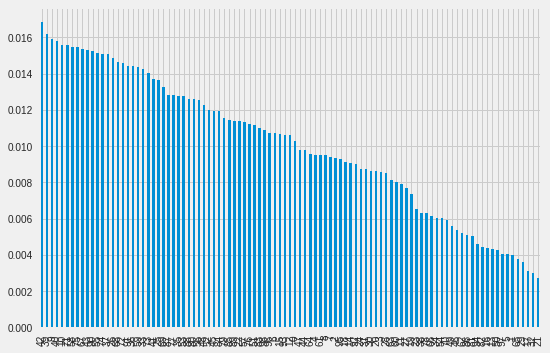

In [225]:
RF_imp['importance'].plot.bar()

In [227]:
RF_imp[RF_imp['importance']>0.01]

,feature,importance
42,avg_Distance,0.016842
39,%_end_evening,0.016208
9,Total_Distance,0.015892
40,%_end_afternoon,0.015800
10,Total_Distance_ex,0.015589
71,std_end_evening,0.015551
58,avg_Distance_wk,0.015448
75,std_Distance_ex,0.015447
67,std_start_evening,0.015350
43,avg_Distance_ex,0.015289


In [229]:
RF_imp[RF_imp['importance']<0.006]

,feature,importance
70,std_end_night,0.005926
49,%_travel_long,0.005585
46,%_time_long,0.005361
62,%_time_long_wk,0.005207
86,std_end_night_wk,0.005102
81,std_travel_long,0.005052
94,std_time_long_wk,0.004603
82,std_start_night_wk,0.004437
16,Count_travel_long,0.004412
13,Count_time_long,0.004317


In [ ]:
samp = socio[income]
samp['TripEnd_B01ID_9'] = mobility['TripEnd_B01ID_9'] #most important
samp['TripStart_B01ID_4'] = mobility['TripStart_B01ID_4'] #least important

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#sample of the most important factor for predictin income
#avg number of trips for lower income
samp[samp['IndIncome2002_B02ID_1']==1]['TripEnd_B01ID_9'].mean()

1.3994252873563218

In [ ]:
#avg number of trips for middle income

samp[samp['IndIncome2002_B02ID_2']==1]['TripEnd_B01ID_9'].mean()

1.6370967741935485

In [ ]:
#avg number of trips for higher income
samp[samp['IndIncome2002_B02ID_3']==1]['TripEnd_B01ID_9'].mean()

1.7831715210355987

In [ ]:
#sample of the least important factor for predicting income
#avg number of trips for lower income

samp[samp['IndIncome2002_B02ID_1']==1]['TripStart_B01ID_4'].mean()

0.004310344827586207

In [ ]:
#avg number of trips for middle income

samp[samp['IndIncome2002_B02ID_2']==1]['TripStart_B01ID_4'].mean()

0.004032258064516129

In [ ]:
#avg number of trips for higher income
samp[samp['IndIncome2002_B02ID_3']==1]['TripStart_B01ID_4'].mean()

0.003236245954692557

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report the model performance
print('Mean Accuracy: %.3f' % (mean(n_scores)))

Mean Accuracy: 0.579
